## Explaratory Data Analysis
#### on Pride car ads, scraped and processed through Bama.ir website

#### Importing libraries

In [2]:
import pandas as pd
import numpy as np
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading datasets (cleaned & engineered versions)
##### - Using MySQL server connection
##### - Using csv file

In [6]:
connection = pymysql.connect(
    host='localhost',
    user='root',
    password='samet021',
    database='iranian_cars_db',
    charset='utf8mb4'
)

query = 'SELECT * FROM pride_cars'
df = pd.read_sql(query, connection)

connection.close()

df = df.drop(['id', 'created_at'], axis=1)     # Useless columns

print('Cleaned dataset shape:', df.shape)
df.head(3)

C:\Users\Kiarash\AppData\Local\Temp\ipykernel_12836\3426199749.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


Cleaned dataset shape: (539, 10)


,brand,name,model,trim,year,mileage,fuel,transmission,body_status,price
0,pride,صندوق دار,پراید,ساده,1389,355000,بنزینی,دنده ای,گلگیر تعویض,345000000
1,pride,صندوق دار,پراید,ساده,1386,325000,بنزینی,دنده ای,گلگیر رنگ,320000000
2,pride,151,پراید,GX,1404,0,بنزینی,دنده ای,بدون رنگ,680000000


In [8]:
df_eng = pd.read_csv('D:/AIjourney/projects/Pride Ads Project/CSV/pride_ads_engineered_1.csv',encoding='utf-8-sig')

df_eng = df_eng.drop('Unnamed: 0', axis=1)     # Useless column

print('Engineered dataset shape:', df_eng.shape)
df_eng.head(3)

Engineered dataset shape: (539, 11)


,brand,name,model,trim,year,mileage,fuel,transmission,body_status,price,age
0,pride,2,پراید,1,1389,355000,1,1,3,345000000,15
1,pride,2,پراید,1,1386,325000,1,1,8,320000000,18
2,pride,7,پراید,10,1404,0,1,1,15,680000000,0


---


### Part 1 : Data Quality and Integrity

In [10]:

print("Missing values:")
print(df_eng.isnull().sum())

duplicates = df_eng.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")       # It detected 19 duplicated rows, but I checked and they were different by multiple features!
                                               # Still needs to be reviewed in future commits !!!
# duplicates = df_eng[df_eng.duplicated(keep=False)]
# print(duplicates)                           

Missing values:
brand           0
name            0
model           0
trim            0
year            0
mileage         0
fuel            0
transmission    0
body_status     0
price           0
age             0
dtype: int64

Duplicate rows: 19


In [12]:
# OUtlier with IQR

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Outlier detection (IQR method):")
for col in ['price', 'mileage', 'year']:
    if col in df_eng.columns:
        outliers, lower, upper = detect_outliers_iqr(df_eng, col)
        print(f"{col}: {len(outliers)} outliers ({lower:.0f} to {upper:.0f})")
        
# Optional: removing outliers (comment out to keep)
for col in ['price', 'mileage', 'year']:
    outliers, lower, upper = detect_outliers_iqr(df_eng, col)           # Not sure if to remove them or not, but sounds reasonable
    df_eng = df_eng[~df_eng.index.isin(outliers.index)]


print('Engineered datset shape after outlier removal:', df_eng.shape)

Outlier detection (IQR method):
price: 1 outliers (-75000000 to 925000000)
mileage: 9 outliers (-203750 to 602250)
year: 0 outliers (1370 to 1414)
Engineered datset shape after outlier removal: (529, 11)


### Part 2 : Univariate Analysis

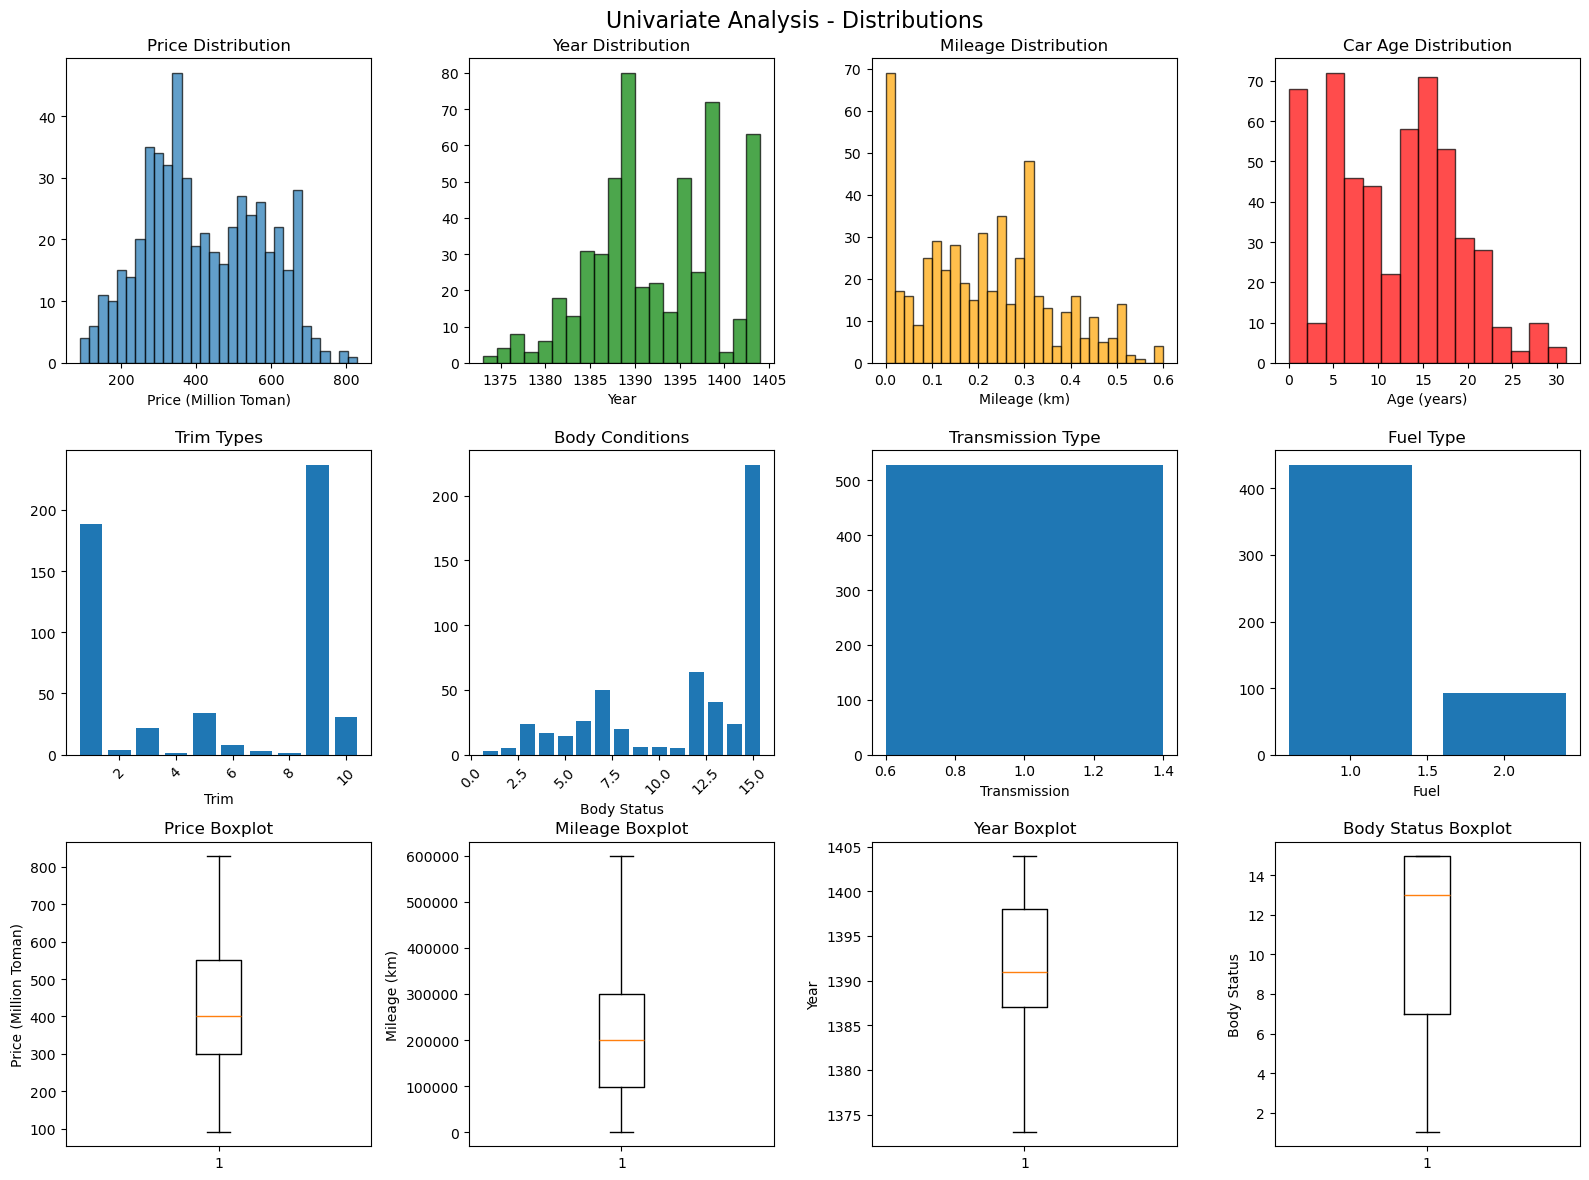

In [18]:
# Distribution plots for all columns
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Univariate Analysis - Distributions', fontsize=16)

# Plot 1: Price distribution
axes[0,0].hist(df_eng['price']/1e6, bins=30, edgecolor='black', alpha=0.7)
axes[0,0].set_xlabel('Price (Million Toman)')
axes[0,0].set_title('Price Distribution')

# Plot 2: Year distribution
axes[0,1].hist(df_eng['year'], bins=20, edgecolor='black', alpha=0.7, color='green')
axes[0,1].set_xlabel('Year')
axes[0,1].set_title('Year Distribution')

# Plot 3: Mileage distribution
axes[0,2].hist(df_eng['mileage']/1e6, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0,2].set_xlabel('Mileage (km)')
axes[0,2].set_title('Mileage Distribution')

# Plot 4: Age distribution
axes[0,3].hist(df_eng['age'], bins=15, edgecolor='black', alpha=0.7, color='red')
axes[0,3].set_xlabel('Age (years)')
axes[0,3].set_title('Car Age Distribution')

# Plot 5: Trim distribution
trim_counts = df_eng['trim'].value_counts()  #.head(10)
axes[1,0].bar(trim_counts.index, trim_counts.values)
axes[1,0].set_xlabel('Trim')
axes[1,0].set_title('Trim Types')
axes[1,0].tick_params(axis='x', rotation=45)

# Plot 6: Body status distribution
body_counts = df_eng['body_status'].value_counts()  #.head(8)
axes[1,1].bar(body_counts.index, body_counts.values)
axes[1,1].set_xlabel('Body Status')
axes[1,1].set_title('Body Conditions')
axes[1,1].tick_params(axis='x', rotation=45)

# Plot 7: Transmission distribution
trans_counts = df_eng['transmission'].value_counts()
axes[1,2].bar(trans_counts.index, trans_counts.values)
axes[1,2].set_xlabel('Transmission')
axes[1,2].set_title('Transmission Type')

# Plot 8: Fuel distribution
fuel_counts = df_eng['fuel'].value_counts()
axes[1,3].bar(fuel_counts.index, fuel_counts.values)
axes[1,3].set_xlabel('Fuel')
axes[1,3].set_title('Fuel Type')

# Plot 9: Price boxplot
axes[2,0].boxplot(df_eng['price']/1e6)
axes[2,0].set_ylabel('Price (Million Toman)')
axes[2,0].set_title('Price Boxplot')

# Plot 10: Mileage boxplot
axes[2,1].boxplot(df_eng['mileage'])
axes[2,1].set_ylabel('Mileage (km)')
axes[2,1].set_title('Mileage Boxplot')

# Plot 11: Year boxplot
axes[2,2].boxplot(df_eng['year'])
axes[2,2].set_ylabel('Year')
axes[2,2].set_title('Year Boxplot')

# Plot 11: Year boxplot
axes[2,3].boxplot(df_eng['body_status'])
axes[2,3].set_ylabel('Body Status')
axes[2,3].set_title('Body Status Boxplot')

# Remove empty subplot
#axes[2,3].axis('off')

plt.tight_layout()
plt.show()

### Part 3 : Bivariate & Multivariate Analysis

In [80]:
df_eng.groupby('trim')['price'].mean()

trim
1     2.781713e+08
2     3.012500e+08
3     3.482727e+08
4     3.500000e+08
5     3.654412e+08
6     3.937500e+08
7     3.983333e+08
8     4.980000e+08
9     5.220338e+08
10    6.515774e+08
Name: price, dtype: float64

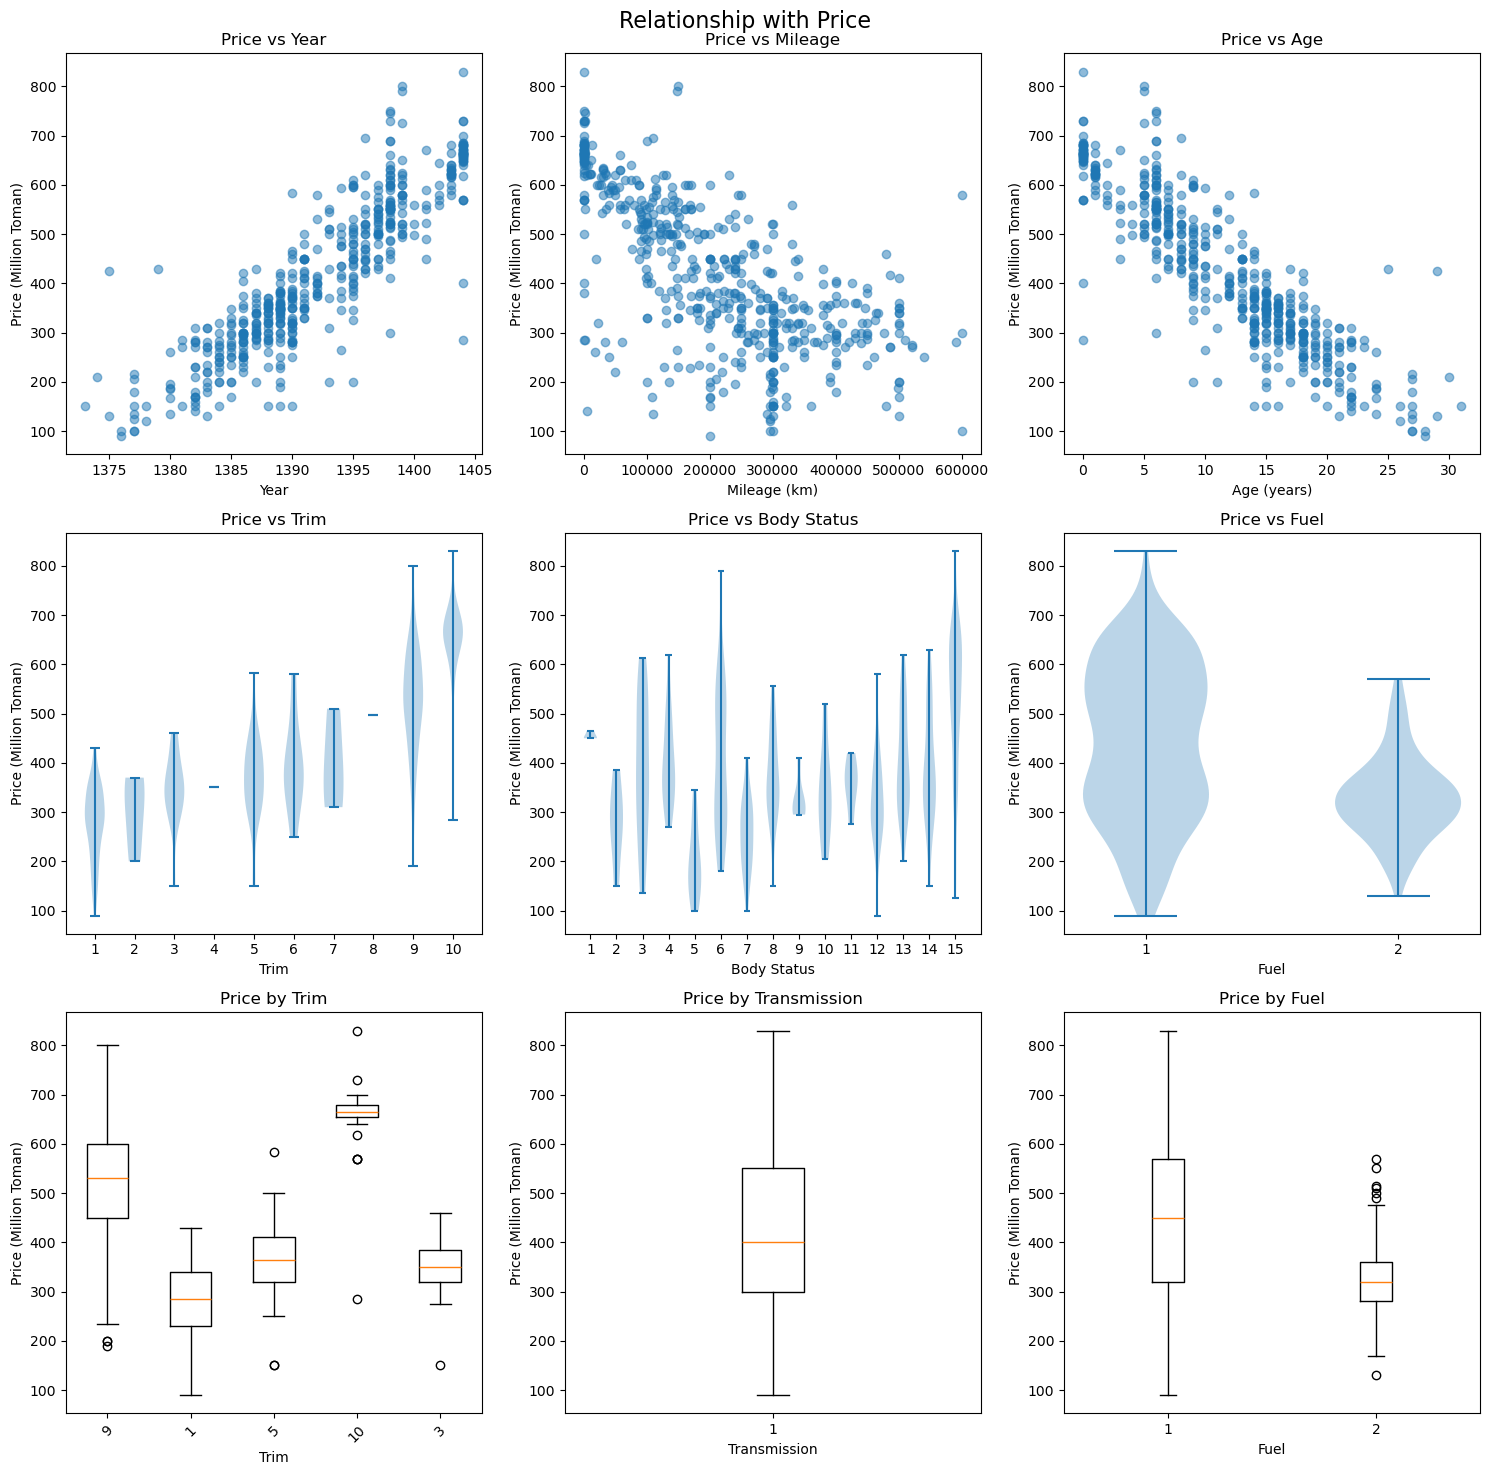

In [96]:

# Relationship with Price 1
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Relationship with Price', fontsize=16)

axes[0,0].scatter(df_eng['year'], df_eng['price']/1e6, alpha=0.5)
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Price (Million Toman)')
axes[0,0].set_title('Price vs Year')

axes[0,1].scatter(df_eng['mileage'], df_eng['price']/1e6, alpha=0.5)
axes[0,1].set_xlabel('Mileage (km)')
axes[0,1].set_ylabel('Price (Million Toman)')
axes[0,1].set_title('Price vs Mileage')
#axes[0,1].set_xlim(0, 2e6) # Set the x-axis limits

axes[0,2].scatter(df_eng['age'], df_eng['price']/1e6, alpha=0.5)
axes[0,2].set_xlabel('Age (years)')
axes[0,2].set_ylabel('Price (Million Toman)')
axes[0,2].set_title('Price vs Age')

# Relationships with price 2 -----------------------------------------------------

axes[1,0].violinplot([df_eng[df_eng['trim']==cat]['price']/1e6 for cat in sorted(df_eng['trim'].unique())])
axes[1,0].set_xticks(range(1, len(df_eng['trim'].unique())+1))
axes[1,0].set_xlabel('Trim')
axes[1,0].set_ylabel('Price (Million Toman)')
axes[1,0].set_title('Price vs Trim')

axes[1,1].violinplot([df_eng[df_eng['body_status']==cat]['price']/1e6 for cat in sorted(df_eng['body_status'].unique())])
axes[1,1].set_xticks(range(1, len(df_eng['body_status'].unique())+1))
axes[1,1].set_xlabel('Body Status')
axes[1,1].set_ylabel('Price (Million Toman)')
axes[1,1].set_title('Price vs Body Status')

axes[1,2].violinplot([df_eng[df_eng['fuel']==cat]['price']/1e6 for cat in sorted(df_eng['fuel'].unique())])
axes[1,2].set_xticks(range(1, len(df_eng['fuel'].unique())+1))
axes[1,2].set_xlabel('Fuel')
axes[1,2].set_ylabel('Price (Million Toman)')
axes[1,2].set_title('Price vs Fuel')

# -3---------------------------------------------------------------------------------

# box plots
trim_price_data = []
trim_labels = []
for trim in df_eng['trim'].value_counts().head(5).index:#for trim in df_eng['trim'].value_counts().head(8).index:
    trim_price_data.append(df_eng[df_eng['trim'] == trim]['price']/1e6)
    trim_labels.append(trim)

axes[2,0].boxplot(trim_price_data, labels=trim_labels)
axes[2,0].set_xlabel('Trim')
axes[2,0].set_ylabel('Price (Million Toman)')
axes[2,0].set_title('Price by Trim')
axes[2,0].tick_params(axis='x', rotation=45)

trans_price_data = []
for trans in df_eng['transmission'].unique():
    trans_price_data.append(df_eng[df_eng['transmission'] == trans]['price']/1e6)

axes[2,1].boxplot(trans_price_data, labels=df_eng['transmission'].unique())
axes[2,1].set_xlabel('Transmission')
axes[2,1].set_ylabel('Price (Million Toman)')
axes[2,1].set_title('Price by Transmission')

fuel_price_data = []
for fuel in df_eng['fuel'].unique():
    fuel_price_data.append(df_eng[df_eng['fuel'] == fuel]['price']/1e6)

axes[2,2].boxplot(fuel_price_data, labels=df_eng['fuel'].unique())
axes[2,2].set_xlabel('Fuel')
axes[2,2].set_ylabel('Price (Million Toman)')
axes[2,2].set_title('Price by Fuel')

plt.tight_layout()
plt.show()

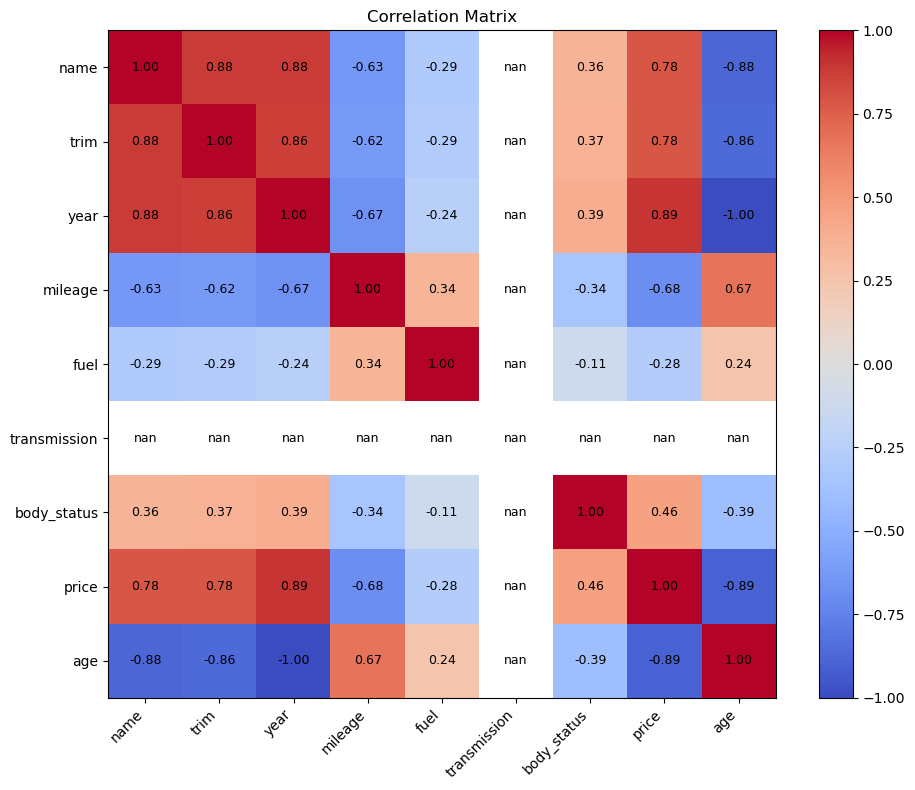

Top correlations with Price:
  year: 0.891
  trim: 0.784
  name: 0.781
  body_status: 0.455
  fuel: -0.275
  mileage: -0.685
  age: -0.891
  transmission: nan


In [98]:
# Correlation matrix | heatmap
numeric_cols = df_eng.select_dtypes(include=[np.number]).columns
corr_matrix = df_eng[numeric_cols].corr()

plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Add correlation values
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', 
                ha='center', va='center', color='black', fontsize=9)

plt.tight_layout()
plt.show()

# Print top correlations with Price
print("Top correlations with Price:")
price_corr = corr_matrix['price'].sort_values(ascending=False)
for feature, corr in price_corr.items():
    if feature != 'price':
        print(f"  {feature}: {corr:.3f}")

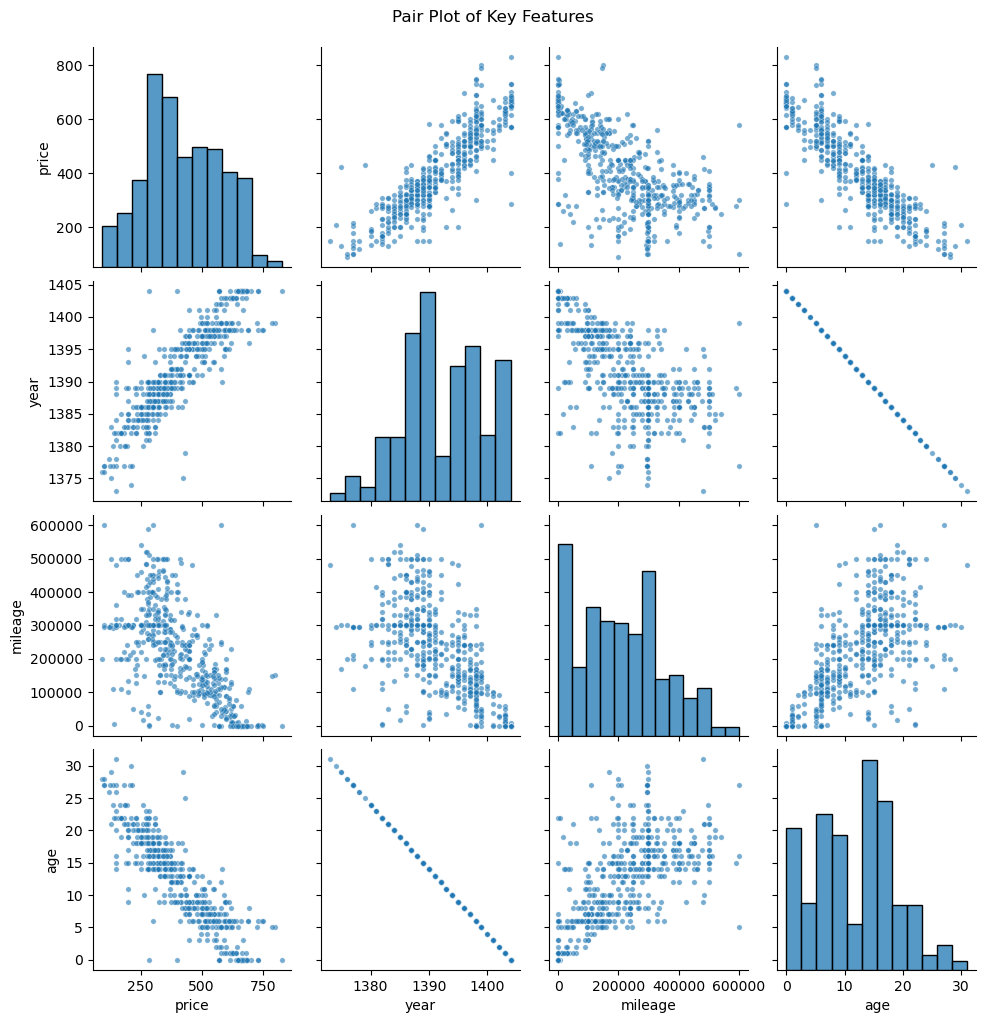

In [108]:
# Pair plot for key numerical features

key_features = ['price', 'year', 'mileage', 'age']
if all(col in df_eng.columns for col in key_features):
    pairplot_data = df_eng[key_features].copy()
    pairplot_data['price'] = pairplot_data['price'] / 1e6  # Convert to million
    
    sns.pairplot(pairplot_data, plot_kws={'alpha': 0.6, 's': 15})
    plt.suptitle('Pair Plot of Key Features', y=1.02)
    plt.show()

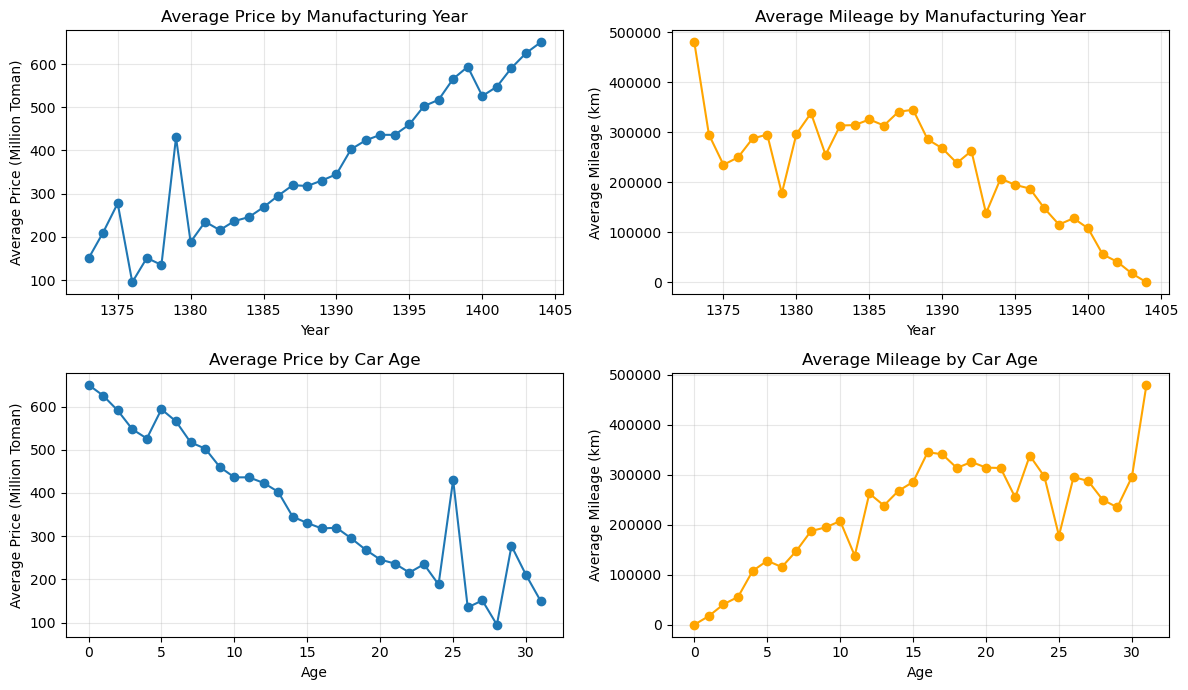


----Price by Age groups----

                mean  count
age                        
(0, 5]    594.821429     56
(5, 10]   511.964286    140
(10, 15]  364.682927    123
(15, 20]  295.457143    112
(20, 30]  207.716981     53


C:\Users\Kiarash\AppData\Local\Temp\ipykernel_12836\473420996.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_price_stats = df_eng.groupby(age_groups)['price'].agg(['mean', 'count'])


In [114]:
# Average trends
fig, axes = plt.subplots(2, 2, figsize=(12, 7))

# Average Price by Year
avg_price_by_year = df_eng.groupby('year')['price'].mean() / 1e6
axes[0,0].plot(avg_price_by_year.index, avg_price_by_year.values, marker='o')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Average Price (Million Toman)')
axes[0,0].set_title('Average Price by Manufacturing Year')
axes[0,0].grid(True, alpha=0.3)

# Average Mileage by Year
avg_mileage_by_year = df_eng.groupby('year')['mileage'].mean()
axes[0,1].plot(avg_mileage_by_year.index, avg_mileage_by_year.values, marker='o', color='orange')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Average Mileage (km)')
axes[0,1].set_title('Average Mileage by Manufacturing Year')
axes[0,1].grid(True, alpha=0.3)

# Average Price by Year
avg_price_by_age = df_eng.groupby('age')['price'].mean() / 1e6
axes[1,0].plot(avg_price_by_age.index, avg_price_by_age.values, marker='o')
axes[1,0].set_xlabel('Age')
axes[1,0].set_ylabel('Average Price (Million Toman)')
axes[1,0].set_title('Average Price by Car Age')
axes[1,0].grid(True, alpha=0.3)

# Average Mileage by Year
avg_mileage_by_age = df_eng.groupby('age')['mileage'].mean()
axes[1,1].plot(avg_mileage_by_age.index, avg_mileage_by_age.values, marker='o', color='orange')
axes[1,1].set_xlabel('Age')
axes[1,1].set_ylabel('Average Mileage (km)')
axes[1,1].set_title('Average Mileage by Car Age')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Age analysis
print("\n----Price by Age groups----\n")
age_groups = pd.cut(df_eng['age'], bins=[0, 5, 10, 15, 20, 30])
age_price_stats = df_eng.groupby(age_groups)['price'].agg(['mean', 'count'])
age_price_stats['mean'] = age_price_stats['mean'] / 1e6
print(age_price_stats)

---

#### Saving the updated dataset
##### Just to make sure that both MySQL and csv formats of the dataset have their columns in lowercase..

In [123]:
df_eng.to_csv('D:/AIjourney/projects/Pride Ads Project/CSV/pride_ads_engineered.csv', encoding='utf-8-sig')
print('New Engineered dataset has been overwrited and saved.')

New Engineered dataset has been overwrited and saved.


In [125]:
df_eng.head(3)
# checking column names

,brand,name,model,trim,year,mileage,fuel,transmission,body_status,price,age
0,pride,2,پراید,1,1389,355000,1,1,3,345000000,15
1,pride,2,پراید,1,1386,325000,1,1,8,320000000,18
2,pride,7,پراید,10,1404,0,1,1,15,680000000,0
